# Libraries

In [28]:
import csv
import os
import json
import umap
import textacy
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Articles

In [29]:
articles = []

dir = "data/biomass/"
files = os.listdir(dir)  # Set folder and files

for filename in files:

    f = open(dir + filename)
    r = f.read()
    data = json.loads(r)

    # Parse

    try:

        year = int(data[0]["publish_date"].split(" ")[0].split("-")[0])  # Set year

        title = data[0]["title"]  # Set Title

        url = data[0]["url"]  # Set URL
        if any(x in url for x in {"feeds.", "rss.", "briefing"}):
            continue  # Blacklist (Bob Dylan's case)
        # if not any(
        #     x in url
        #     for x in {
        #         "wsj.com",
        #         "usatoday.com",
        #         "nytimes.com",
        #         "latimes.com",
        #         "nypost.com",
        #         "washingtonpost.com",
        #         "chicagotribune.com",
        #         "chron.com",
        #         "nydailynews.com",
        #         "theguardian.com",
        #     }
        # ):
        #     continue  # Whitelist

        entities = data[0]["story_tags"]  # Set sentities
        if len(entities) > 100:
            continue  # Set max
        if len(entities) <= 1:
            continue  # Set min

        subjects = []
        orgs = []
        people = []

        for entity in entities:

            name = entity["tag"]

            if name[0] == "—":
                continue  # Remove listings
            if name.startswith("geonames_"):
                continue  # Skip geotag
            if "readability" in name:
                continue  # Clean
            if "cliff_clavin_" in name:
                continue  # Clean
            if "nyt_labeller" in name:
                continue  # Clean

            name = " ".join(name.split())  # Merge multiple spaces
            name = name.replace(".", "")  # Remove dots
            name = name.replace(",", "")  # Remove commas

            if entity["tag_set"] == "nyt_labels":
                subjects.append(name)

            elif entity["tag_set"] == "cliff_organizations":
                if name.startswith("US "):
                    name = name[3:]  # Remove prefix
                if name.endswith(" Corp"):
                    name = name[:-5]  # Remive postfix
                if name.endswith(" Inc"):
                    name = name[:-4]  # Remive postfix
                if name.endswith(" LCC"):
                    name = name[:-4]  # Remive postfix
                if name[0].islower():
                    continue  # Remove lowercase
                if name[1].isupper():
                    continue  # Remove acronyms
                orgs.append(name)

            elif entity["tag_set"] == "cliff_people":
                if "/" in name:
                    continue  # Clean
                if name[1].isupper():
                    continue  # Remove uppercase
                if name[0].islower():
                    continue  # Remove lowercase
                if len(name.split(" ")) == 1:
                    continue  # remove those with no family name
                people.append(name)

        if len(orgs) > 0 and len(subjects) > 0:
            articles.append(
                [
                    year,
                    title,
                    url,
                    list(set(subjects)),
                    list(set(orgs)),
                    list(set(people)),
                ]
            ) # Add these articles with actors only


    except:
        continue  # In case of error


articles = pd.DataFrame(
    articles, columns=["year", "title", "url", "subjects", "orgs", "people"]
)  # Dataset

articles = articles.drop_duplicates(subset=["url"])  # Remove articles with the same URL

print('\n' + str(articles.shape[0]))

articles.sample(10)



18153


,year,title,url,subjects,orgs,people
12324,2020,"NIPOST, firm to bridge energy shortfall in rem...",http://feedproxy.google.com/~r/bestnaira/BTbw/...,"[finances, light, energy and power, electric l...",[Ukpa hansa energy solutions],[Ismail Adewusi]
6370,2020,Is Plant 'Intelligence' Just a Human Fantasy?,https://gizmodo.com/is-plant-intelligence-just...,"[environment, biology and biochemistry, resear...","[La Nazione Delle Piante, University of Bristo...","[Gen-ichiro Arimura, Elizabeth Van Volkenburgh..."
6302,2017,Extreme air pollution in Ireland caused by ‘bu...,https://www.irishtimes.com/news/health/extreme...,"[air pollution, environment]","[Irish Times, European Commission, Lancet medi...","[Colin O’Dowd, Denis Naughten]"
2378,2018,David Hughes: Politics versus the future: Cana...,http://vancouversun.com/opinion/op-ed/david-hu...,"[energy and power, air pollution, environment,...","[Parkland Institute, Canadian Centre for Polic...","[Justin Trudeau, David Hughes, Rachel Notley, ..."
7868,2020,Global Market Outlook For The Gasification Mar...,https://www.thestreet.com/press-releases/globa...,[economic conditions and trends],"[Mitsubishi Heavy Industries Ltd, General Elec...",[]
9231,2017,‘Decimated’: Germany’s birds disappear as inse...,https://news.mongabay.com/2017/10/decimated-ge...,"[animals, insects, environment, research, birds]","[University of New Brunswick, Federal Agency f...","[Hirundo rustica, Katja Schulz, Andreas Trepte..."
18077,2018,FSI carries out 'complete revamp' of forest fi...,http://www.business-standard.com/article/pti-s...,"[fires and firemen, forests and forestry, fire...","[Tamil Nadu Forest Department, Union Ministry ...",[Saibal Dasgupta]
13177,2018,"Environmental protection,conservation vital re...",http://dailypioneer.com/state-editions/dehradu...,"[environment, education and schools]",[Forest Research Institute],"[Balvinder Singh Khosa, Arti Chaudhary, Yuva K..."
1319,2011,"Week's High Impact Diaries: December 25-31, 2010",http://www.dailykos.com/storyonly/2011/1/2/115...,[books and literature],"[Firefox, White House, Republican, Town Patrio...","[Mike Bloomberg, Russell Pearce, Andy Stern, K..."
19129,2013,I'll have the top one: Britons plump for bunkh...,http://www.guardian.co.uk/travel/2013/jun/22/r...,[travel and vacations],[National Trust],"[Richard Roworth, David Elliott, Keith Legge]"


## Entities

In [30]:
entities = np.empty((0, 12), dtype=object)

years_template = {
    2011: 0,
    2012: 0,
    2013: 0,
    2014: 0,
    2015: 0,
    2016: 0,
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 0,
}

for index, row in articles.iterrows():

    url = row["url"]
    year = row["year"]
    title = row["title"]
    cooccurrences = list(set(row["subjects"] + row["orgs"] + row["people"]))

    for entity in row["subjects"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "subject",
                            1,
                            None,
                            None,
                            None,
                            None,
                            None,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][8][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 8][0][year] += 1  # Year
            entities[index, 9][0].append(url)  # URL
            entities[index, 10][0].append(title)  # Title
            entities[index, 11][0] += co  # Co-occurrences

    for entity in row["orgs"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "org",
                            1,
                            None,
                            None,
                            None,
                            None,
                            None,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][8][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 8][0][year] += 1  # Year
            entities[index, 9][0].append(url)  # URL
            entities[index, 10][0].append(title)  # Title
            entities[index, 11][0] += co  # Co-occurrences

    for entity in row["people"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "person",
                            1,
                            None,
                            None,
                            None,
                            None,
                            None,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][8][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 8][0][year] += 1  # Year
            entities[index, 9][0].append(url)  # URL
            entities[index, 10][0].append(title)  # Title
            entities[index, 11][0] += co  # Co-occurrences


entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        'x',
        'y',
        'cluster',
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset

entities_all.sort_values(by=["frequency"], ascending=False).head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
14,environment,subject,7515,None,None,None,None,None,"{2011: 184, 2012: 147, 2013: 355, 2014: 489, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[Karan Madan, University of Edinburgh, Sunil D..."


## Scale

In [31]:
frequency = entities_all['frequency'].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
frequency_scaled
# df = pd.DataFrame(x_scaled)
entities_all['frequency_norm'] = frequency_scaled

entities_all.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
62064,Shram Yogi Maan-Dhan Yojana,person,1,None,None,None,None,None,"{2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, ...",[https://www.narendramodi.in/social-media-corn...,[Social Media Corner 19 July 2019],"[Ramesh Chand Tomar, International Energy Agen...",0.0


# Analysis

## Filter

In [32]:
n = 50 # Number of rows by type

top_subjects = entities_all.loc[entities_all['type'] == 'subject'].sort_values(by=["frequency"], ascending=False).head(n)
top_orgs = entities_all.loc[entities_all['type'] == 'org'].sort_values(by=["frequency"], ascending=False).head(n)
top_people = entities_all.loc[entities_all['type'] == 'person'].sort_values(by=["frequency"], ascending=False).head(n)

entities = pd.concat([top_subjects, top_orgs, top_people])

entities.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
90,Anand Vihar,person,62,None,None,None,None,None,"{2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 7, ...",[https://economictimes.indiatimes.com/news/pol...,[Delhi air quality to be very hazardous for ne...,"[environment, Haryana & Punjab, Indian Institu...",0.008118


## Linear regression

In [33]:
for i, row in entities.iterrows():
    
    x = list(row['years'].keys())
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row['years'].values())

    regression = LinearRegression()
    regression.fit(x, y)

    slope = regression.coef_[0]
    entities.at[i, 'slope'] = slope

entities.sort_values(by=["slope"], ascending=False).head(1)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
2069,Mahatma Gandhi,person,46,0.509091,None,None,None,None,"{2011: 0, 2012: 0, 2013: 3, 2014: 4, 2015: 8, ...",[https://www.business-standard.com/article/pti...,"[Pb, Hary paddy growers 'soft targets', say ex...","[Hary paddy, farmers, environment, energy and ...",0.005989


## Colors

In [34]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():
    entities.at[i, 'color'] = mcolors.to_hex(cmap(norm(row['slope'])))
    # entities.at[i, 'color'] = list(cmap(norm(row['slope'])))[:-1]

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
14,environment,subject,7515,159.557576,#b40426,None,None,None,"{2011: 184, 2012: 147, 2013: 355, 2014: 489, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[Karan Madan, University of Edinburgh, Sunil D...",1.0


## TF-IDF

In [35]:


doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(
    # entities["cooccurrences"].tolist(), tf_type="linear", idf_type="standard"
    entities["cooccurrences"].tolist(), tf_type="linear", idf_type="smooth"
)

list(dictionary.items())[:5]


[('Karan Madan', 32533),
 ('University of Edinburgh', 62033),
 ('Sunil Dahiya', 58042),
 ('Greenpeace India', 23850),
 ('Bhure Lal', 6904)]

## UMAP

In [40]:

reducer = umap.UMAP(
    random_state=42, n_components=2, n_neighbors=2, min_dist=0.1, metric="hellinger"
)

embedding = reducer.fit_transform(doc_term_matrix) # Reducer
embedding = align_points_to_grid(embedding) # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900)) # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding. astype(int)

index_embedding = 0 # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

entities.sample(5)


 * creating mesh with size 39 39
 * filling mesh


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
4123,Tyler Robson,person,46,2.30303,#b40426,731,121,9,"{2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, ...",[https://www.thestreet.com/press-releases/the-...,[The Valens Company Enters Australia's Rapidly...,"[finances, Cannvalate Pty Ltd, Valens GroWorks...",0.005989
0,finances,subject,3509,67.509091,#b40426,626,647,7,"{2011: 116, 2012: 101, 2013: 220, 2014: 244, 2...",[https://www.prnewswire.com/news-releases/glob...,[Global Medical Cannabis Sales Projected to Gr...,[Linn Country Planning and Building Department...,0.466862
93,agriculture,subject,1455,34.90303,#b40426,205,900,2,"{2011: 42, 2012: 34, 2013: 47, 2014: 76, 2015:...",[https://www.thehindu.com/news/national/other-...,"[Pollution: U.P. farmers seek govt. support, U...","[finances, farmers, Gopal Singh, Janta Vedic C...",0.193505
25,computers and the internet,subject,435,10.212121,#b40426,542,563,9,"{2011: 11, 2012: 10, 2013: 22, 2014: 35, 2015:...",[https://manilastandard.net/tech/tech-news/338...,[Consumers in Asia Pacific to benefit most fro...,"[Raimund Klein, Stephan Neumeier, Kaspersky, S...",0.057759
257,Navy,org,119,-0.163636,#c6d6f1,857,500,6,"{2011: 12, 2012: 13, 2013: 16, 2014: 11, 2015:...",[http://news.sciencemag.org/scienceinsider/201...,[House Panel Takes Next Step Toward New Patent...,"[Ray LaHood, James S Rhodes, John Vaughn, Gold...",0.015704


## Clustering

In [41]:
# cluster_selection_epsilon = radius
# min_samples = number of close elements to create a set

clusterer = hdbscan.HDBSCAN(min_samples=3, cluster_selection_epsilon=0.2)

clusterer.fit(embedding)
clusters = clusterer.labels_

index_embedding = 0
for index, row in entities.iterrows():
    entities.loc[index, "cluster"] = clusters[index_embedding]
    index_embedding += 1

entities.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
1139,National Academy of Sciences,org,233,4.078788,#b40426,436,794,9,"{2011: 10, 2012: 3, 2013: 11, 2014: 23, 2015: ...",[https://news.mongabay.com/2020/03/east-africa...,[East Africa’s reefs being fished at unsustain...,"[Nyawira Muthiga, animals, fishing sport, fish...",0.030876


# Plotting

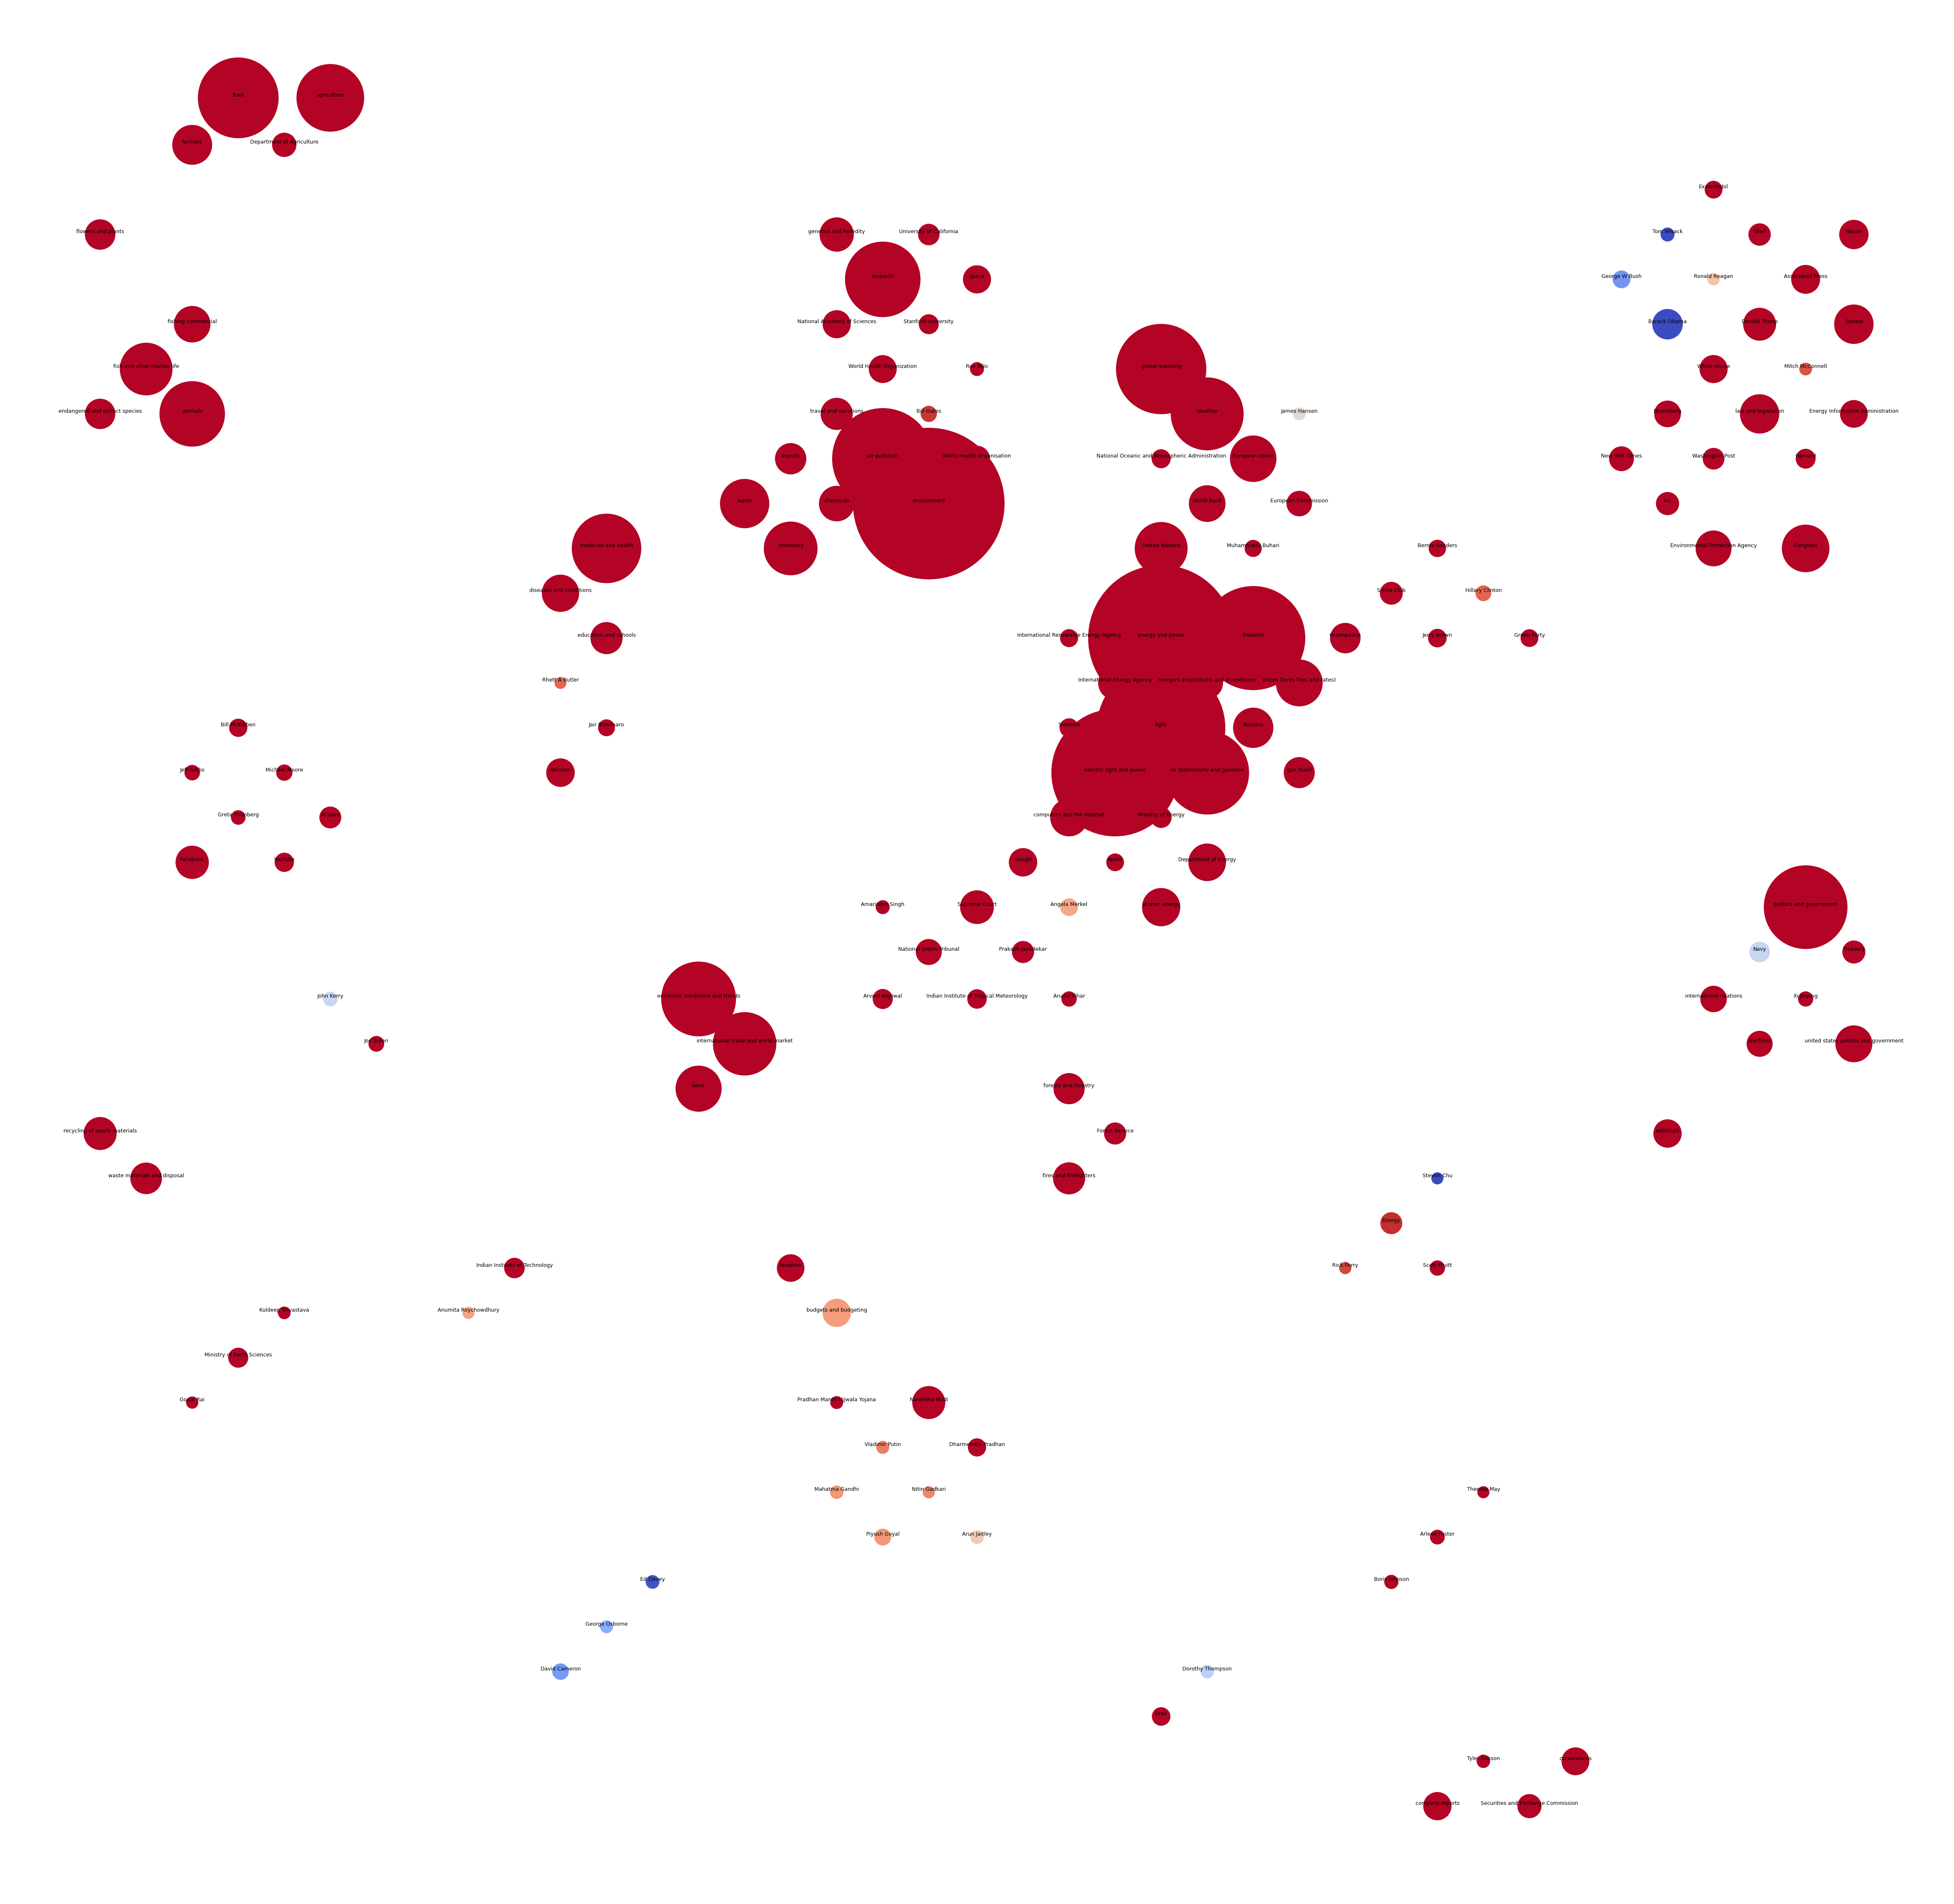

In [42]:
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(entities['x'].to_list(), entities['y'].to_list(), s=entities['frequency'].to_list(), c=entities['color'].to_list())

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row['name'], xy=(row['x'], row['y']), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


# Save

In [43]:
entities.to_csv("src/data/entities.csv", index=False)